#Setup environment

In [0]:
import numpy as np
import pylab as plt
import math
from scipy import linalg as la

In [2]:
# pip = Python package manager; "!" means "run at system level"
!pip install control
import control as ctrl
# this scipy module implements many of the routines in ctrl
from scipy import signal as sig

    100% |████████████████████████████████| 174kB 5.2MB/s 
  Running setup.py bdist_wheel for control ... - \ done
  Stored in directory: /root/.cache/pip/wheels/d2/8f/04/16760efa8227635eced77a90b880f874bfbb7c91d6272bda14
Successfully built control


In [0]:
# Function definition
def Jacobian(g,y,d=1e-4):
  """
  approximate derivative via finite-central-differences 

  input:
    g - function - g : R^n -> R^m
    y - n array
    (optional)
    d - scalar - finite differences displacement parameter

  output:
    Dg(y) - m x n - approxim   ation of Jacobian of g at y
  """
  # given $g:\mathbb{R}^n\rightarrow\mathbb{R}^m$:
  # $$D_y g(y)e_j \approx \frac{1}{2\delta}(g(y+\delta e_j) - g(y - \delta e_j)),\ \delta\ll 1$$
  e = np.identity(len(y))
  Dyg = []
  for j in range(len(y)):
      Dyg.append((.5/d)*(g(y+d*e[j]) - g(y-d*e[j])))
  return np.array(Dyg).T

def numerical_simulation(f,t,x,t0=0.,dt=1e-4,ut=None,ux=None,utx=None,return_u=False):
  """
  simulate x' = f(x,u) 

  input:
    f : R x X x U --> X - vector field
      X - state space (must be vector space)
      U - control input set
    t - scalar - final simulation time
    x - initial condition; element of X

    (optional:)
    t0 - scalar - initial simulation time
    dt - scalar - stepsize parameter
    return_u - bool - whether to return u_

    (only one of:)
    ut : R --> U
    ux : X --> U
    utx : R x X --> U

  output:
    t_ - N array - time trajectory
    x_ - N x X array - state trajectory
    (if return_u:)
    u_ - N x U array - state trajectory
  """
  t_,x_,u_ = [t0],[x],[]
  
  inputs = sum([1 if u is not None else 0 for u in [ut,ux,utx]])
  assert inputs <= 1, "more than one of ut,ux,utx defined"

  if inputs == 0:
    assert not return_u, "no input supplied"
  else:
    if ut is not None:
      u = lambda t,x : ut(t)
    elif ux is not None:
      u = lambda t,x : ux(x)
    elif utx is not None:
      u = lambda t,x : utx(t,x)

  while t_[-1]+dt < t:
    if inputs == 0:
      _t,_x = t_[-1],x_[-1]
      dx = f(t_[-1],x_[-1]) * dt
    else:
      _t,_x,_u = t_[-1],x_[-1],u(t_[-1],x_[-1])
      dx = f(_t,_x,_u) * dt
      u_.append( _u )

    x_.append( _x + dx )
    t_.append( _t + dt )

  if return_u:
    return np.asarray(t_),np.asarray(x_),np.asarray(u_)
  else:
    return np.asarray(t_),np.asarray(x_)

# Section 3: Operating point and stability analysis

In [0]:
# Variables
m = 1.
I = 0.01
g = 9.81
beta = 0.1


def f_NL(t,x,u):
  tau_l, tau_r = u
  theta, dtheta, qh, dqh, qv, dqv = x
  ddtheta = (tau_r/I)-(tau_l/I)
  ddqh = ((tau_r+tau_l)*np.sin(theta)-(beta*dqh))/m
  ddqv = -g+((tau_r+tau_l)*np.cos(theta)-(beta*dqv))/m
  return np.array([dtheta,ddtheta, dqh, ddqh, dqv, ddqv])



#def h_NL(t,x,u):
 # theta,dtheta = x 
  #return np.array([l*np.sin(theta)])

#def h_NL(t,x,u):
  #tau_l, tau_r = u
 # thta, dtheta, qh, dqh, qv, dqv = x
#  return np.array([dtheta,ddtheta, dqh, ddqh, d])

def h_NL(t,x,u):
  tau_l, tau_r = u
  theta, dtheta, qh, dqh, qv, dqv = x
  return np.array([qh, qv, theta])

#LTI 
#def f_LTI(t,x,u):
#  theta,dtheta = x
#  ddtheta = (m*g*l*theta - gamma*dtheta + l*u) / (m*l**2)
#  return np.array([dtheta,ddtheta])

## 3.1: Operating point

In [0]:
th_e = 0.
dth_e = 0.
qh_e = 5.
dqh_e = 0.
qv_e = 5.
dqv_e = 0.

x_e = np.array([th_e, dth_e, qh_e, dqh_e, qv_e, dqv_e]) # set equilibrium point for chosen u
u_e = np.array([g*m/2,g*m/2])       # set non-zeru u

assert np.allclose(0.,f_NL(0.,x_e,u_e)) # test

## 3.2: Linearization

In [0]:
# Values of array A, B, C, D. Linearized using Jacobian. Calculated on paper
A = np.array([[0, 1, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0],
              [0, 0, 0, 1, 0, 0],
              [g, 0, 0, -beta/m, 0, 0],
              [0, 0, 0, 0, 0, 1],
              [0, 0, 0, 0, 0, -beta/m]])

B = np.array([[0, 0],
              [-1/I, 1/I],
              [0, 0],
              [0, 0],
              [0, 0],
              [1/m, 1/m]])
             

C = np.array([[0., 0., 1., 0., 0., 0.],
              [0., 0., 0., 0., 1., 0.],
              [1., 0., 0., 0., 0., 0.]])

D = np.array([[0., 0.],
              [0., 0.],
              [0., 0.]])

In [0]:
# Proof that I have the right calculation
assert np.allclose(A, Jacobian(lambda x : f_NL(0.,x,u_e),x_e,1e-3))

assert np.allclose(B, Jacobian(lambda u : f_NL(0.,x_e,u),u_e))

assert np.allclose(C, Jacobian(lambda x : h_NL(0.,x,u_e),x_e))

assert np.allclose(D, Jacobian(lambda u : h_NL(0.,x_e,u),u_e)) 

## 3.3: Stability of the LTI system

In [8]:
Re_eigvals = np.real(la.eigvals(A))

if np.any(Re_eigvals > 0):
  print('A is *unstable*')
  
elif np.all(Re_eigvals < 0):
  print('A is *asymptotically stable*')
  
else:
  print('A is *neutrally stable*')

A is *neutrally stable*


In [9]:
la.eigvals(A)

array([ 0. +0.j, -0.1+0.j,  0. +0.j,  0. +0.j,  0. +0.j, -0.1+0.j])

# Section 4: Design using Eigenvalue Placement

## 4.1: Controller

In [10]:
sigma = 7.
omega = 0.25

# , -sigma+4.j*omega,-sigma-4.j*omega, 
# -sigma+5.j*omega,-sigma-5.j*omega, -sigma+6.j*omega,-sigma-6.j*omega

poles = [-sigma, -sigma+1.j*omega, -sigma-2e-5, -sigma-3e-5, 
         -sigma-4e-5, -sigma-1.j*omega]
poles = [-sigma+1e-5, -sigma-1e-5, -sigma-2e-5, -14.-3e-5, 
         -sigma-4e-5, -sigma+2e-5]
poles = [-sigma+1e-7, -sigma-1e-5, -sigma-2e-5, -14.-3e-5, 
         -sigma-4e-5, -sigma+1e-5]

K = ctrl.place(A,B,poles)

# vector field
def f_L(t,x,u):
  return np.matmul((A-np.matmul(B,K)), x)

/usr/local/lib/python3.6/dist-packages/scipy/signal/ltisys.py:3185: UserWarning: Convergence was not reached after maxiter iterations.
You asked for a relative tolerance of 0.001000 we got 1.000000
  warnings.warn(err_msg)


In [11]:
la.eigvals(A-np.matmul(B,K))

array([-14.00003   +0.00000000e+00j,  -6.99539872+0.00000000e+00j,
        -7.00002786+3.49122094e-05j,  -7.00002786-3.49122094e-05j,
        -7.00001434+0.00000000e+00j,  -7.00000037+0.00000000e+00j])

In [12]:
la.eigvals(A)

array([ 0. +0.j, -0.1+0.j,  0. +0.j,  0. +0.j,  0. +0.j, -0.1+0.j])

In [13]:
K

array([[  8.70307229,   1.00828077, -30.16953657,  -3.32514913,
         24.50008944,   6.95001278],
       [ 13.07690731,   1.35723551, -25.27770725,  -0.92336551,
         24.50008944,   6.95001278]])

In [0]:
# simulation duration, timestep
T = 2.
dt = 1e-2

# non-zero initial state
theta0 = 1*np.pi/4
dtheta0 = 2.
qh0 = 10.
dqh0 = 10.
qv0 = 10.
dqv0 = 10.

x0 = np.array([theta0,dtheta0, qh0, dqh0, qv0, dqv0])

# zero input
def u(t):
  ut = np.array([1, 2])
  return ut

# numerical simulation returns:
# t_ - size N array
# x_ - size N x 2 array (since the state is 2-dimensional)
t_,x_ = numerical_simulation(f_L,T,x0,ut=u,dt=dt)
#t_1,x_1 = numerical_simulation(f_NL,T,x0,ut=u,dt=dt)

# the first column contains theta(t), the second column contains dtheta(t)
# (I append an underscore "_" to remind myself these are time series)
theta_,dtheta_, qh_, dqh_, qv_, dqv_ = x_[:,0],x_[:,1],x_[:,2],x_[:,3],x_[:,4],x_[:,5]

Text(0.5,0,'time $t$')

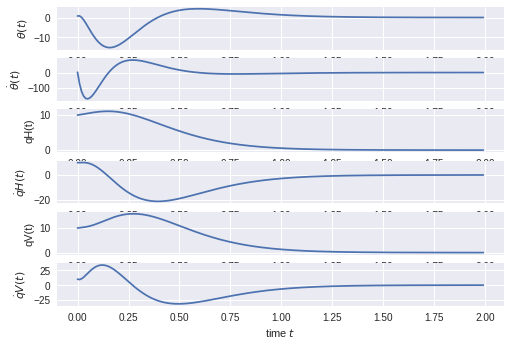

In [15]:
# plot theta
plt.figure()
plt.subplot(6,1,1)
plt.plot(t_,theta_,label='(Linear)')
plt.ylabel(r'$\theta(t)$')

# plot dtheta
plt.subplot(6,1,2)
plt.plot(t_,dtheta_,label='(Linear)')
plt.ylabel(r'$\dot{\theta}(t)$')
plt.xlabel(r'time $t$')

# plot qH
plt.subplot(6,1,3)
plt.plot(t_,qh_,label='(Linear)')
plt.ylabel(r'qH(t)')
plt.xlabel(r'time $t$')

# plot dqH
plt.subplot(6,1,4)
plt.plot(t_,dqh_,label='(Linear)')
plt.ylabel(r'$\dotqH(t)$')
plt.xlabel(r'time $t$')

# plot qV
plt.subplot(6,1,5)
plt.plot(t_,qv_,label='(Linear)')
plt.ylabel(r'qV(t)')
plt.xlabel(r'time $t$')

# plot dqV
plt.subplot(6,1,6)
plt.plot(t_,dqv_,label='(Linear)')
plt.ylabel(r'$\dotqV(t)$')
plt.xlabel(r'time $t$')

## 4.2: Observer

In [16]:
# Calculated using .place
zeta = 5.5
poles = [-zeta,-zeta-1e-6,-zeta-2e-6,-zeta-3e-6,-zeta-4e-6,-zeta-5e-6]
poles = np.sort(-np.random.rand(6))-zeta
print(poles)
L = ctrl.place(A.T,C.T,poles).T

def obs_L(t,x,u):
  return np.dot((A-np.dot(L,C)), x)

[-6.20792045 -6.00710092 -5.915453   -5.72240783 -5.6520072  -5.53587242]


In [17]:
la.eigvals(A-np.matmul(L,C))

array([-6.20792045+0.j, -6.00710092+0.j, -5.915453  +0.j, -5.53587242+0.j,
       -5.6520072 +0.j, -5.72240783+0.j])

In [18]:
L

array([[-0.20547344,  0.04552911, 11.78708562],
       [-1.19122462,  0.26404773, 34.69382471],
       [11.54472704,  0.07747133, -0.19862944],
       [32.71403839,  0.44152609,  8.67835452],
       [ 0.07751306, 11.50894917,  0.04389309],
       [ 0.44176798, 32.51039271,  0.25015895]])

In [0]:
# simulation duration, timestep
T = 1.25
dt = 1e-2

# non-zero initial state
e_theta0 = 1*np.pi/4
e_dtheta0 = 2.
e_qh0 = 10.
e_dqh0 = 10.
e_qv0 = 10.
e_dqv0 = 10.

e0 = np.array([e_theta0,e_dtheta0, e_qh0, e_dqh0, e_qv0, e_dqv0])

# zero input
def u(t):
  ut = 0
  return ut

# this could equivalently be written in one line:
# u = lambda t : np.sin(t)

# numerical simulation returns:
# t_ - size N array
# e_ - size N x 2 array (since the state is 2-dimensional)
t_,e_ = numerical_simulation(obs_L,T,e0,ut=u,dt=dt)

# the first column contains theta(t), the second column contains dtheta(t)
# (I append an underscore "_" to remind myself these are time series)
e_theta_,e_dtheta_, e_qh_, e_dqh_, e_qv_, e_dqv_ = e_[:,0],e_[:,1],e_[:,2],e_[:,3],e_[:,4],e_[:,5]

Text(0.5,0,'time $t$')

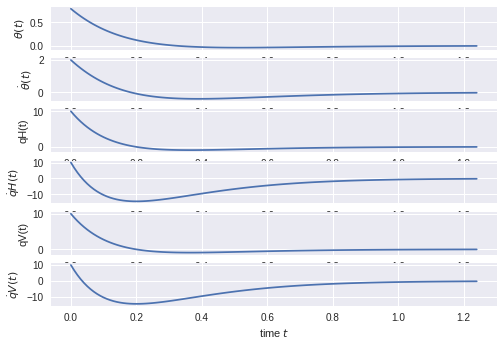

In [20]:
# plot e_theta
plt.figure()
plt.subplot(6,1,1)
plt.plot(t_,e_theta_,label='(Linear)')
plt.ylabel(r'$\theta(t)$')

# plot e_dtheta
plt.subplot(6,1,2)
plt.plot(t_,e_dtheta_,label='(Linear)')
plt.ylabel(r'$\dot{\theta}(t)$')

# plot e_qH
plt.subplot(6,1,3)
plt.plot(t_,e_qh_,label='(Linear)')
plt.ylabel(r'qH(t)')

# plot e_dqH
plt.subplot(6,1,4)
plt.plot(t_,e_dqh_,label='(Linear)')
plt.ylabel(r'$\dotqH(t)$')

# plot e_qV
plt.subplot(6,1,5)
plt.plot(t_,e_qv_,label='(Linear)')
plt.ylabel(r'qV(t)')

# plot e_dqV
plt.subplot(6,1,6)
plt.plot(t_,e_dqv_,label='(Linear)')
plt.ylabel(r'$\dotqV(t)$')
plt.xlabel(r'time $t$')

# phase portrait
#plt.figure()
#plt.subplot(1,1,1)
#plt.plot(error_,derror_,label='(Linear)')
#plt.ylabel(r'$\dot{e}(t)$')
#plt.xlabel(r'$e(t)$');

## 4.3: Closing the loop

In [0]:
def f_obs_L(t,x,u): 
  D = np.zeros([12,12])
  D[0:6,0:6] = A-np.matmul(B,K)
  D[0:6,6:12] = np.matmul(B,K)
  D[6:12,6:12] = A-np.matmul(L,C)
  return np.matmul(D, x)

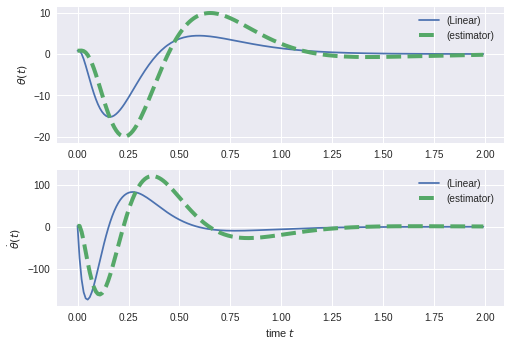

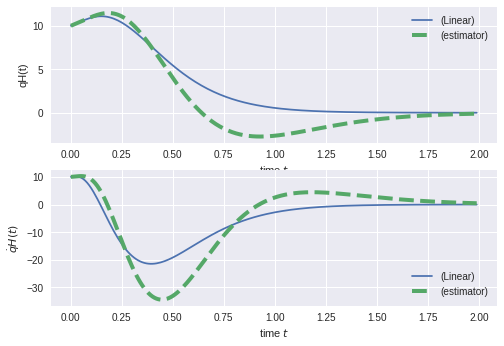

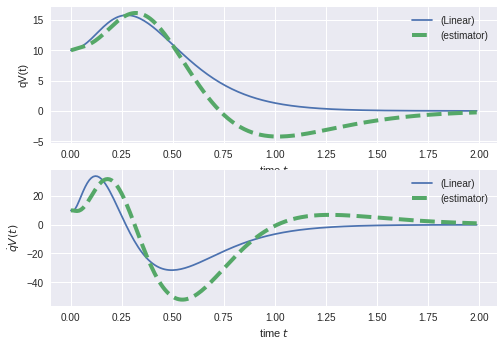

In [49]:
# simulation duration, timestep
T = 2
dt = 1e-2

# zero input
def u(t):
  ut = 0
  return ut

# non-zero initial state
theta0 = 1*np.pi/4
dtheta0 = 2.
qh0 = 10.
dqh0 = 10.
qv0 = 10.
dqv0 = 10.
e_theta0 = 1*np.pi/4
e_dtheta0 = 2.
e_qh0 = 10.
e_dqh0 = 10.
e_qv0 = 10.
e_dqv0 = 10.


x0 = np.array([theta0,dtheta0, qh0, dqh0, qv0, dqv0, e_theta0,e_dtheta0, e_qh0, e_dqh0, e_qv0, e_dqv0])
x1 = np.array([theta0,dtheta0, qh0, dqh0, qv0, dqv0])


# numerical simulation returns:
# t_ - size N array
# x_ - size N x 2 array (since the state is 2-dimensional)
t_,x_ = numerical_simulation(f_obs_L,T,x0,ut=u,dt=dt)
t1_,x1_ = numerical_simulation(f_L,T,x1,ut=u,dt=dt)

# the first column contains theta(t), the second column contains dtheta(t)
# (I append an underscore "_" to remind myself these are time series)
theta_,dtheta_, qh_, dqh_, qv_, dqv_, e_theta_, e_dtheta_, e_qh_, e_dqh_, e_qv_, e_dqv_  = x_[:,0],x_[:,1],x_[:,2],x_[:,3],x_[:,4],x_[:,5], x_[:,6],x_[:,7],x_[:,8],x_[:,9],x_[:,10],x_[:,11]
theta_L,dtheta_L,qh_L,dqh_L,qv_L,dqv_L = x1_[:,0],x1_[:,1],x1_[:,2],x1_[:,3],x1_[:,4],x1_[:,5]

# we'll use the Matplotlib library for plots
# (as the name suggests, it has a similar interface to MATLAB)
import pylab as plt
plt.figure()

# plot theta
plt.figure()
plt.subplot(2,1,1)
plt.plot(t_,theta_L,label='(Linear)')
plt.plot(t_,theta_,'--',lw=4,label='(estimator)')
plt.ylabel(r'e_$\theta(t)$')
plt.ylabel(r'$\theta(t)$')
plt.legend()

# plot dtheta
plt.subplot(2,1,2)
plt.plot(t_,dtheta_L,label='(Linear)')
plt.plot(t_,dtheta_,'--',lw=4,label='(estimator)')
plt.ylabel(r'$\dot{\theta}(t)$')
plt.xlabel(r'time $t$')
plt.legend()

plt.figure()
# plot qH
plt.subplot(2,1,1)
plt.plot(t_,qh_L,label='(Linear)')
plt.plot(t_,qh_,'--',lw=4,label='(estimator)')
plt.ylabel(r'qH(t)')
plt.xlabel(r'time $t$')
plt.legend()

# plot dqH
plt.subplot(2,1,2)
plt.plot(t_,dqh_L,label='(Linear)')
plt.plot(t_,dqh_,'--',lw=4,label='(estimator)')
plt.ylabel(r'$\dotqH(t)$')
plt.xlabel(r'time $t$')
plt.legend()

plt.figure()
# plot qV
plt.subplot(2,1,1)
plt.plot(t_,qv_L,label='(Linear)')
plt.plot(t_,qv_,'--',lw=4,label='(estimator)')
plt.ylabel(r'qV(t)')
plt.xlabel(r'time $t$')
plt.legend()

# plot dqV
plt.subplot(2,1,2)
plt.plot(t_,dqv_L,label='(Linear)')
plt.plot(t_,dqv_,'--',lw=4,label='(estimator)')
plt.ylabel(r'$\dotqV(t)$')
plt.xlabel(r'time $t$')
plt.legend()


#plt.figure()
#plt.subplot(1,1,1)
#plt.plot(theta_,dtheta_,label='(Linear)')
#plt.ylabel(r'$\dot{\theta}(t)$')
#plt.xlabel(r'${\theta}(t)$')

#plt.figure()
#plt.subplot(1,1,1)
#plt.plot(qh_,dqh_,label='(Linear)')
#plt.xlabel(r'qH(t)$')
#plt.ylabel(r'$\dotqH(t)$')

#plt.figure()
#plt.subplot(1,1,1)
#plt.plot(qv_,dqv_,label='(Linear)')
#plt.xlabel(r'qV(t)$')
#plt.ylabel(r'$\dotqV(t)$')

#plt.figure()
#plt.subplot(1,1,1)
#plt.plot(e_theta_,e_dtheta_,label='(Linear)')
#plt.ylabel(r'e_$\dot{\theta}(t)$')
#plt.xlabel(r'e_${\theta}(t)$')

#plt.figure()
#plt.subplot(1,1,1)
#plt.plot(e_qh_,e_dqh_,label='(Linear)')
#plt.xlabel(r'e_qH(t)$')
#plt.ylabel(r'e_$\dotqH(t)$')

#plt.figure()
#plt.subplot(1,1,1)
#plt.plot(e_qv_,e_dqv_,label='(Linear)')
#plt.xlabel(r'e_qV(t)$')
#plt.ylabel(r'e_$\dotqV(t)$')

## 4.4: Closing the loop (NL)

In [0]:
# vector field
def f_cl(t,z,u): 
  
  # extract controlled system and observer system state from full system state
  #x,x_hat = z[:2],z[2:]
  x,x_hat = z[:6],z[6:]
  
  # compute control input using observer state
  mu = -np.dot(x_hat,np.transpose(K))
  u = mu + u_e
  
  y_e = np.array([qh_e, qv_e, th_e])
  
  
  # output from controlled system and observer system
  eta = h_NL(t,x,u) - y_e
  eta_hat = np.dot(x_hat,np.transpose(C)) + np.dot(u,np.transpose(D))
  
  # dynamics of controlled system and observer system
  dx = f_NL(t,x,u) 
  dx_hat = np.dot(x_hat,np.transpose(A)) + np.dot(mu,np.transpose(B)) + np.dot((eta-eta_hat),np.transpose(L))
  
  # combine dynamics of controlled system and observer system
  dz = np.hstack((dx,dx_hat))

  return dz

In [0]:

# simulation duration, timestep
T = 4
dt = 1e-2

# NOTE:  nonlinear system's initial state needs to be VERY close to x_e
theta0, dtheta0, qh0, dqh0, qv0, dqv0 = .001, .001, qh_e + .001, .001, qv_e + .001, .001

# What should this be?
theta0_hat = 0.
dtheta0_hat = 0.
qh0_hat = 1.
dqh0_hat = 0.
qv0_hat = 1.
dqv0_hat = 0.

# non-zero initial state
z0 = np.array([theta0, dtheta0, qh0, dqh0, qv0, dqv0, theta0_hat, dtheta0_hat, qh0_hat, dqh0_hat, qv0_hat, dqv0_hat])

# zero input
def u(t):
  ut = np.array([0.,0.]) 
  return ut

# this could equivalently be written in one line:
# u = lambda t : np.sin(t)

# numerical simulation returns:
# t_ - size N array
# z_ - size N x 2 array (since the state is 2-dimensional)
t_,z_ = numerical_simulation(f_cl,T,z0,ut=u,dt=dt)

# the first column contains theta(t), the second column contains dtheta(t)
# (I append an underscore "_" to remind myself these are time series)
x_ = z_[:,:6]
x_hat_ = z_[:,6:]
theta_,dtheta_, qh_, dqh_, qv_, dqv_ = np.transpose(x_)
theta_hat_,dtheta_hat_, qh_hat_, dqh_hat_, qv_hat_, dqv_hat_ = np.transpose(x_hat_)

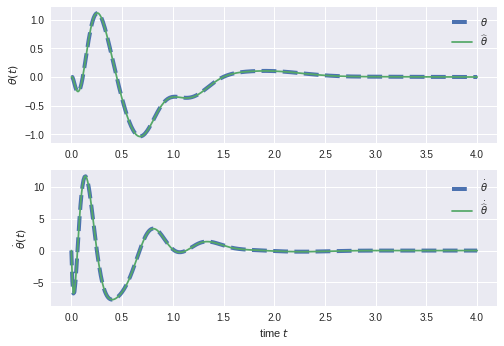

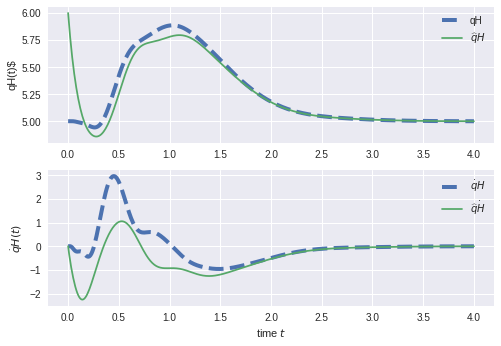

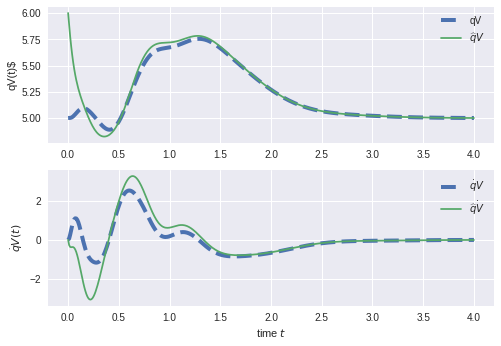

In [26]:
plt.figure()
# plot theta, theta_hat
plt.subplot(2,1,1)
plt.plot(t_,theta_,'--',lw=4,label=r'$\theta$')
plt.plot(t_,theta_hat_ +th_e,label=r'$\widehat{\theta}$')
plt.ylabel(r'$\theta(t)$')
plt.legend()

# plot dtheta, dtheta_hat
plt.subplot(2,1,2)
plt.plot(t_,dtheta_,'--',lw=4,label=r'$\dot{\theta}$')
plt.plot(t_,dtheta_hat_,label=r'$\dot{\widehat{\theta}}$')
plt.ylabel(r'$\dot{\theta}(t)$')
plt.xlabel(r'time $t$')
plt.legend()

# plot qh, qh_hat
plt.figure()
plt.subplot(2,1,1)
plt.plot(t_,qh_,'--',lw=4,label=r'qH')
plt.plot(t_,qh_hat_ +qh_e,label=r'$\widehatqH$')
plt.ylabel(r'qH(t)$')
plt.legend()

# plot dqh, dqh_hat
plt.subplot(2,1,2)
plt.plot(t_,dqh_,'--',lw=4,label=r'$\dotqH$')
plt.plot(t_,dqh_hat_,label=r'$\dot{\widehatqH}$')
plt.ylabel(r'$\dotqH(t)$')
plt.xlabel(r'time $t$')
plt.legend()

# plot qv, qv_hat
plt.figure()
plt.subplot(2,1,1)
plt.plot(t_,qv_,'--',lw=4,label=r'qV')
plt.plot(t_,qv_hat_ +qv_e,label=r'$\widehatqV$')
plt.ylabel(r'qV(t)$')
plt.legend()

# plot dqv, dqv_hat
plt.subplot(2,1,2)
plt.plot(t_,dqv_,'--',lw=4,label=r'$\dotqV$')
plt.plot(t_,dqv_hat_,label=r'$\dot{\widehatqV}$')
plt.ylabel(r'$\dotqV(t)$')
plt.xlabel(r'time $t$')
plt.legend()



#plt.figure()
#plt.subplot(1,1,1)
#plt.plot(theta_,dtheta_,'--',lw=4,label=r'$x$')
#plt.plot(theta_hat_+th_e,dtheta_hat_,label=r'$\widehat{x}$')
#plt.ylabel(r'$\dot{\theta}(t)$')
#plt.xlabel(r'${\theta}(t)$')
#plt.legend();

# Section 5: Sensitivity and Robustness analysis

## 5.2: Root Locus Plot

In [0]:
# code pulled from github

import seaborn as sns

def transfer_function(num, denum):
	"""
		Correctly pads the list of poles and zeros to give
		adequate representation of the transfer function.
		Assume num is smaller than denum.
		Parameters:
		-----------
		- num: coefficients of the zeros [coeff_n, coeff_(n-1), ..., coeff_0]
		- denun: coefficients of the poles: [coeff_n, coeff_(n-1), ..., coeff_0]
		Returns:
		--------
		- tf: 2D numpy array [num, denum]
	"""
	# cast as numpy arrays of type float
	num = np.array(num, dtype=np.float64)
	denum = np.array(denum, dtype=np.float64)

	# get size difference
	size = len(denum) - len(num)
	# create array of zeros to pad with
	temp = np.zeros(size)
	# join 0 pad and numerator
	num = np.concatenate((temp, num))
	# stack num and denum to create final tf representation
	tf = np.vstack((num, denum))

	return tf

def compute_roots(tf, gains):
	"""
	Compute the roots of the characteristic equation of the closed-loop system
	of a given transfer function for a list of gain parameters.
	Concretely, given TF = zeros/poles, and a gain value K, we solve for the 
	characteristic equation roots, that is the roots of poles + (K * zeros).
	Parameters:
	-----------
	- tf: 2D 
	- gains: list of gains
	Returns:
	--------
	- roots: numpy array containing the roots for each gain in gains.
	"""
	num, denum = tf[0], tf[1]
	num_roots = len(np.roots(denum))
	roots = []

	for gain in gains:
		ch_eq = denum +  gain*num
		ch_roots = np.roots(ch_eq)
		ch_roots.sort()
		roots.append(ch_roots)

	# convert final roots list into array
	roots = np.vstack(roots)

	return roots

def plot_root_locus(gains, roots):
	"""
	Plots the root locus of the closed loop system given the provided gains.
	To be filled out later - too lazy
	Parameters:
	-----------
	- gains
	- roots
	Returns:
	--------
	- fig
	- ax
	"""
	# get real and imaginary values
	real_vals = np.real(roots)
	imag_vals = np.imag(roots)

	# possible colors
	colors = ['b', 'm', 'c', 'r', 'g']

	# create figure and axis labels
	fig, ax = plt.subplots()
	ax.set_xlabel('Re')
	ax.set_ylabel('Im')
	ax.axvline(x=0, color='k', lw=1)
	ax.grid(True, which='both')

	# plots a blue "x" for the first roots
	ax.scatter(real_vals[0, :], imag_vals[0, :], 
					marker='x', 
					color='blue')

	# plots a red "o" for the last roots
	ax.scatter(real_vals[-1, :], imag_vals[-1, :],
					marker='o',
					color='red')

	gain_text = ['k = {:1.2f}'.format(k) for k in gains]

	temp_real_vals = real_vals[1:-1, :]
	temp_imag_vals = imag_vals[1:-1, :]
	color_range = range(temp_real_vals.shape[1])

	# plot the rest of the roots in different colors with respect to the regions
	for r, i, j in zip(temp_real_vals.T, temp_imag_vals.T, color_range):
		ax.plot(r, i, color=colors[j])
		
	return fig, ax, gain_text

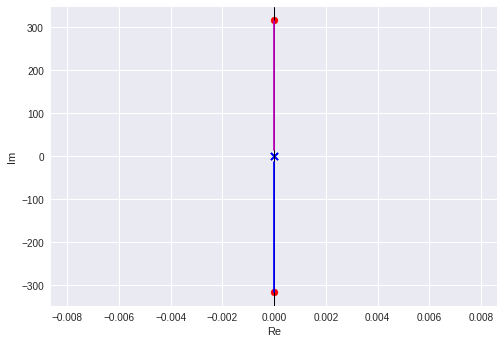

In [28]:
# Using code pulled from github

num = [1]
denum = [I, 0, 0]

GH = transfer_function(num, denum)

# create a list of evenly spaced gains
gains = np.linspace(0.0, 1000.0, num=500)

roots = compute_roots(GH, gains)
fig, ax, text = plot_root_locus(gains, roots)
plt.show()


s^2 + 0.5 s + 100
-----------------
    0.01 s^3



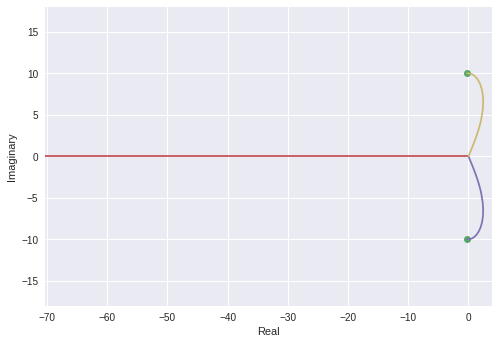

In [37]:
#PID root locus
kp = 0.5
ki = 100.
kd = 1.
num = [kd,kp,ki]
denom = [I,0,0,0]
tfunc =ctrl.tf(num,denom)
print(tfunc)
rloc = ctrl.root_locus(tfunc,PrintGain=True)

We can see from this root locus plot that all k's will produce a point at the Imaginary axis. This means that the system will be neutrally stable. It is impossible to apply a Proportional controller in order to produce an asymptotically stable system.

## 5.3: Nyquist Plot

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


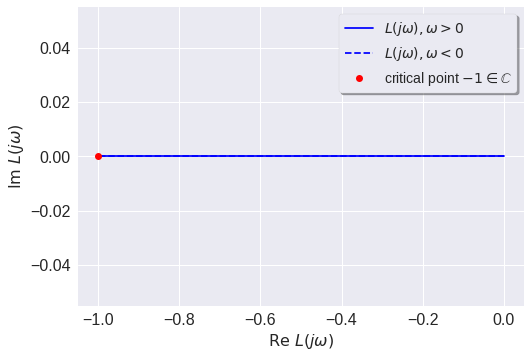

In [30]:
# P controller

k = 1 # kp = 1

L_p = lambda s : (k*(1))/((I)*(s**2))


omega = np.linspace(0.,1e4,1000)

Omega = L_p(1.j*omega)

plt.figure()
ax = plt.subplot(1,1,1); ax.grid('on')
ax.plot(Omega.real,Omega.imag,'b-',label=r'$L(j\omega), \omega > 0$')
ax.plot(Omega.real,-Omega.imag,'b--',label=r'$L(j\omega), \omega < 0$')
ax.plot(-1.,0.,'ro',label=r'critical point $-1\in\mathbb{C}$')
ax.legend(fontsize=14,frameon=True,shadow=True, loc=1)
ax.set_xlabel(r'$\operatorname{Re}\ L(j\omega)$')
ax.set_ylabel(r'$\operatorname{Im}\ L(j\omega)$');

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(16)

We can see that using P controller will not make the system asymptotically stable.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


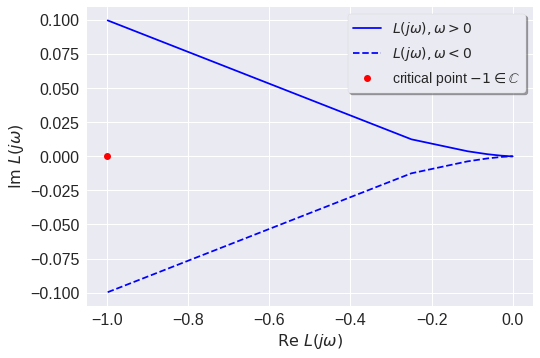

In [31]:
# PI controller

k = 1 # ki = 1, kp = 1

L_pi = lambda s : (k*(s+1)*(1))/((I)*(s**3))


omega = np.linspace(0.,1e4,1000)

Omega = L_pi(1.j*omega)

plt.figure()
ax = plt.subplot(1,1,1); ax.grid('on')
ax.plot(Omega.real,Omega.imag,'b-',label=r'$L(j\omega), \omega > 0$')
ax.plot(Omega.real,-Omega.imag,'b--',label=r'$L(j\omega), \omega < 0$')
ax.plot(-1.,0.,'ro',label=r'critical point $-1\in\mathbb{C}$')
ax.legend(fontsize=14,frameon=True,shadow=True, loc=1)
ax.set_xlabel(r'$\operatorname{Re}\ L(j\omega)$')
ax.set_ylabel(r'$\operatorname{Im}\ L(j\omega)$');

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(16)

When using a PI controller, it does not produce a Nyquist plot that makes a loop.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


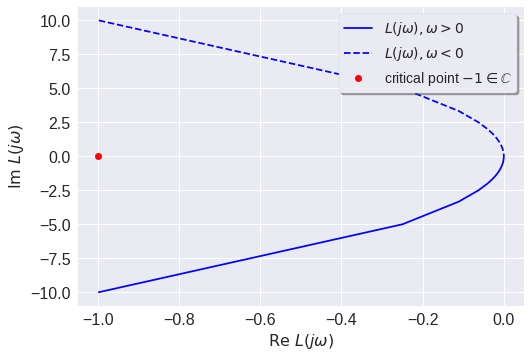

In [32]:
# PD controller

k = 1 # kd = 1, kp = 1

L_pd = lambda s : (k*(s+1)*(1))/((I)*(s**2))


omega = np.linspace(0.,1e4,1000)

Omega = L_pd(1.j*omega)

plt.figure()
ax = plt.subplot(1,1,1); ax.grid('on')
ax.plot(Omega.real,Omega.imag,'b-',label=r'$L(j\omega), \omega > 0$')
ax.plot(Omega.real,-Omega.imag,'b--',label=r'$L(j\omega), \omega < 0$')
ax.plot(-1.,0.,'ro',label=r'critical point $-1\in\mathbb{C}$')
ax.legend(fontsize=14,frameon=True,shadow=True, loc=1)
ax.set_xlabel(r'$\operatorname{Re}\ L(j\omega)$')
ax.set_ylabel(r'$\operatorname{Im}\ L(j\omega)$');

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(16)

When using a PD controller, it does not produce a Nyquist plot that makes a loop.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


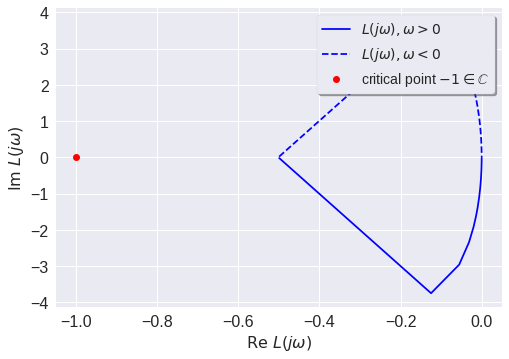

In [33]:
# PID controller

kp = 0.5
ki = 100.
kd = 1.

L_pid = lambda s : ((kd*s**2+kp*s+ki)*(1))/((I)*(s**3))


omega = np.linspace(0.,1e4,1000)

Omega = L_pid(1.j*omega)

plt.figure()
ax = plt.subplot(1,1,1); ax.grid('on')
ax.plot(Omega.real,Omega.imag,'b-',label=r'$L(j\omega), \omega > 0$')
ax.plot(Omega.real,-Omega.imag,'b--',label=r'$L(j\omega), \omega < 0$')
ax.plot(-1.,0.,'ro',label=r'critical point $-1\in\mathbb{C}$')
ax.legend(fontsize=14,frameon=True,shadow=True, loc=1)
ax.set_xlabel(r'$\operatorname{Re}\ L(j\omega)$')
ax.set_ylabel(r'$\operatorname{Im}\ L(j\omega)$');

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(16)

## 5.4 Bode Plot

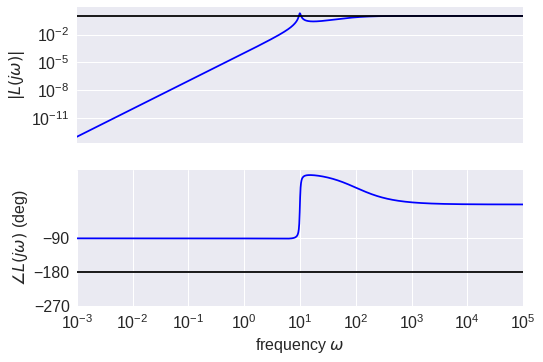

In [34]:
# Sensitivity function 1/1+L

L_sens = lambda s : (s**3)/(s**3+100*s**2+50*s+10000)



omega = np.logspace(-3, 5,1000)
xlim = omega[[0,-1]]

abs_L = np.abs(L_sens(1.j*omega))
angle_L = np.unwrap(np.angle(L_sens(1.j*omega)))*180./np.pi

#critical = (angle_L < -180).nonzero()[0][0]

plt.figure(); axs = []
ax = plt.subplot(2,1,1); ax.grid('on')
ax.loglog(omega,abs_L,'b-')
ax.loglog(xlim,[1.,1.],'k-')
#ax.loglog(omega[critical],abs_L[critical],'ro')
ax.set_ylabel(r'$|L(j\omega)|$')
ax.set_xticks([])
ax.set_xlim(xlim)
axs.append(ax)

ax = plt.subplot(2,1,2); ax.grid('on')
ax.semilogx(omega,angle_L,'b-')
ax.semilogx(xlim,[-180.,-180.],'k-')
#ax.semilogx(omega[critical],angle_L[critical],'ro')
ax.set_xlabel(r'frequency $\omega$')
ax.set_ylabel(r'$\angle L(j\omega)$ (deg)')
ax.set_yticks([-90,-180,-270])
ax.set_xlim(xlim)
axs.append(ax)

for ax in axs:
  for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
               ax.get_xticklabels() + ax.get_yticklabels()):
      item.set_fontsize(16)

## 5.5:  Gain margin, phase margin, and stability margin

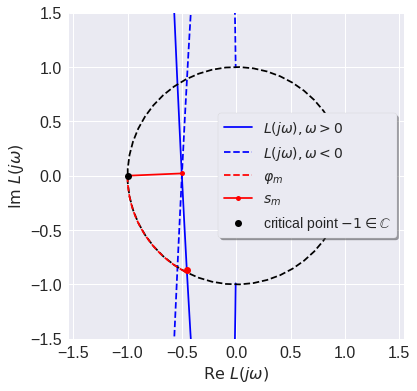

In [35]:

omega = np.linspace(0.75,100,1000)
Omega = L_pid(1.j*omega)

abs_L = np.abs(Omega)
angle_L = np.unwrap(np.angle(Omega))*180./np.pi

circle = np.exp(1.j*np.linspace(0.,2*np.pi))

# index (i.e. entry) of Omega array corresponding to stability margin
#g_m_idx = (angle_L < -180).nonzero()[0][0]
phi_m_idx = np.argmin(np.min(np.abs(Omega - circle[:,np.newaxis]),axis=0))
s_m_idx = np.argmin(np.abs(Omega - (-1.)))

# numerical value of stability margin
#g_m = -1./Omega[g_m_idx].real
phi_m = np.angle(Omega[phi_m_idx])*180./np.pi
phi_m_arc = np.exp(1.j*np.linspace(-180,phi_m)*np.pi/180.)
s_m = np.abs(Omega[s_m_idx] - (-1.))

axs = []

plt.figure(figsize=(6,6))
ax = plt.subplot(1,1,1); ax.grid('on'); ax.axis('equal')
# Omega, i.e. graph of L(j omega)
ax.plot(Omega.real,Omega.imag,'b-',label=r'$L(j\omega), \omega > 0$')
ax.plot(Omega.real,-Omega.imag,'b--',label=r'$L(j\omega), \omega < 0$')
# unit circle
ax.plot(circle.real,circle.imag,'k--')
# stability margins
#ax.plot(-1./g_m,0.,'ro',label=r'$-1/g_m$')
ax.plot(phi_m_arc.real,phi_m_arc.imag,'r--',label=r'$\varphi_m$')
ax.plot(Omega[phi_m_idx].real,Omega[phi_m_idx].imag,'ro')
ax.plot([-1.,Omega[s_m_idx].real],[0.,Omega[s_m_idx].imag],'r.-',ms=10,label=r'$s_m$')
# critical point (-1. + 0.j)
ax.plot(-1.,0.,'ko',label=r'critical point $-1\in\mathbb{C}$')
# legend and labels
ax.legend(fontsize=14,frameon=True,shadow=True)
ax.set_xlabel(r'$\operatorname{Re}\ L(j\omega)$')
ax.set_ylabel(r'$\operatorname{Im}\ L(j\omega)$');
axs.append(ax)
ax.set_xlim([-1.5,1.5])
ax.set_ylim([-1.5,1.5])

for ax in axs:
  for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
               ax.get_xticklabels() + ax.get_yticklabels()):
      item.set_fontsize(16)

In [36]:
num = [kd,kp,ki]
denom = [I,0,0,0]
trf = ctrl.tf(num,denom)
g_m, p_m, s_m, _, _, _ = ctrl.stability_margins(trf)
print("Gain Margin:", g_m)
print("S Margin:", s_m)
print("P Margin:", p_m)





Gain Margin: 2.0000000000000013
S Margin: 0.49937771358691074
P Margin: -57.28483823288374
